In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10


In [2]:
greedy = xr.open_dataset('evals/greedy_baseline.nc')
oracle = xr.open_dataset('evals/mpc_oracle.nc')
rl = xr.open_dataset('evals/testrun7.nc')

In [3]:
greedy = greedy.isel(TI=0, turbbox=0, model_step=0, deterministic=0, ws=0)
oracle = oracle.isel(TI=0, turbbox=0, model_step=0, deterministic=0, ws=0)
rl = rl.isel(TI=0, turbbox=0, deterministic=0, ws=0)

In [16]:
# Calculate the percentage increase in power over the greedy:

oracle["pct_inc"] = (oracle.powerF_a - greedy.powerF_a) / greedy.powerF_a * 100
rl["pct_inc"] = (rl.powerF_a - greedy.powerF_a) / greedy.powerF_a * 100

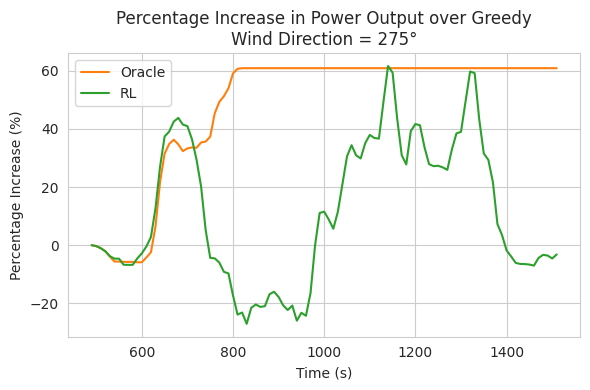

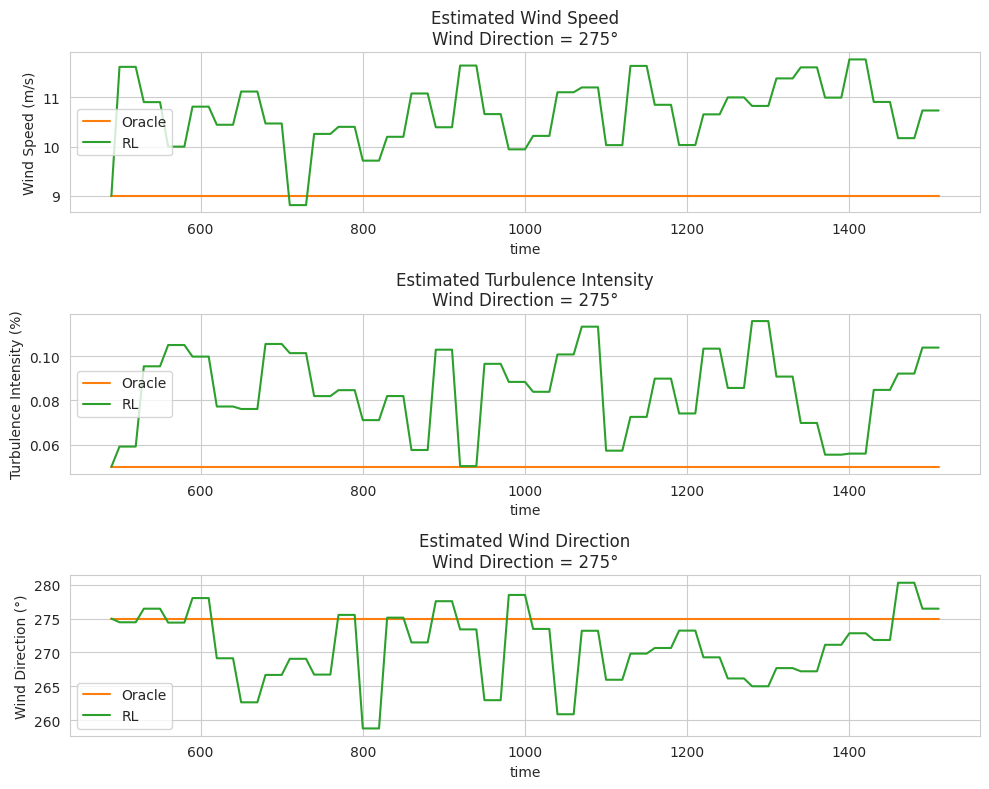

In [52]:
WD = 275
MODEL_STEP = 0

fig, ax = plt.subplots(figsize=(6,4))

oracle.sel(wd=WD).pct_inc.plot(label='Oracle', color='C1', ax=ax)
rl.sel(wd=WD).isel(model_step=MODEL_STEP).pct_inc.plot(label='RL', color='C2', ax=ax)

ax.set_title(f'Percentage Increase in Power Output over Greedy\nWind Direction = {WD}°')
ax.set_ylabel('Percentage Increase (%)')
ax.set_xlabel('Time (s)')
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(3,1, figsize=(10,8))

oracle.sel(wd=WD).estimated_ws.plot(label='Oracle', color='C1', ax=ax[0])
rl.sel(wd=WD).isel(model_step=MODEL_STEP).estimated_ws.plot(label='RL', color='C2', ax=ax[0])
ax[0].set_title(f'Estimated Wind Speed\nWind Direction = {WD}°')
ax[0].set_ylabel('Wind Speed (m/s)')
ax[0].legend()
oracle.sel(wd=WD).estimated_ti.plot(label='Oracle', color='C1', ax=ax[1])
rl.sel(wd=WD).isel(model_step=MODEL_STEP).estimated_ti.plot(label='RL', color='C2', ax=ax[1])
ax[1].set_title(f'Estimated Turbulence Intensity\nWind Direction = {WD}°')
ax[1].set_ylabel('Turbulence Intensity (%)')
ax[1].legend()

oracle.sel(wd=WD).estimated_wd.plot(label='Oracle', color='C1', ax=ax[2])
rl.sel(wd=WD).isel(model_step=MODEL_STEP).estimated_wd.plot(label='RL', color='C2', ax=ax[2])
ax[2].set_title(f'Estimated Wind Direction\nWind Direction = {WD}°')
ax[2].set_ylabel('Wind Direction (°)')
ax[2].legend()


plt.tight_layout()
plt.show()

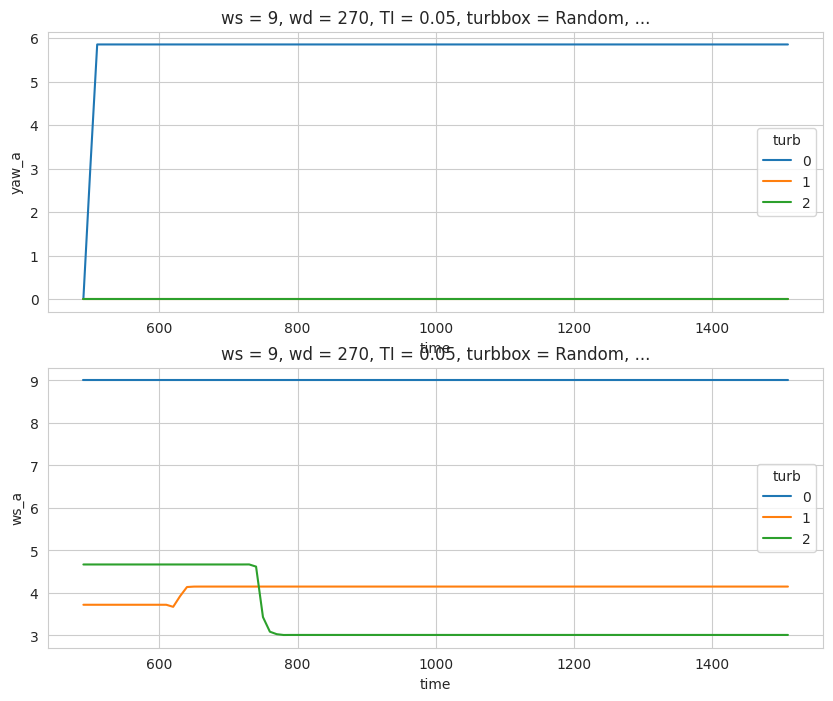

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))
oracle.sel(wd=WD).yaw_a.plot.line(x="time", ax=ax[0])

oracle.sel(wd=WD).ws_a.plot.line(x="time", ax=ax[1])

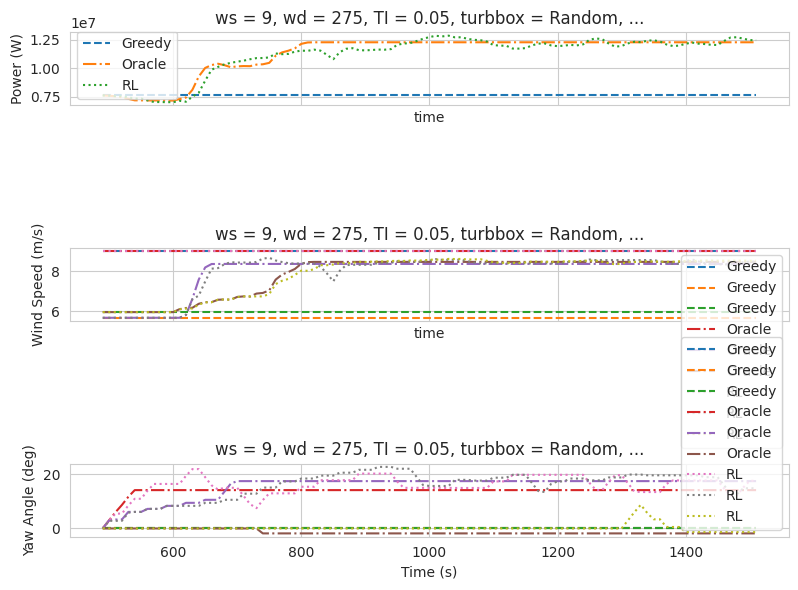

In [43]:
labels = ['Greedy', 'Oracle', 'RL']
linestyles = ['--', '-.', ':']

WD = 275

fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=True)


for i, data_sets in enumerate([greedy, oracle, rl.isel(model_step=-1)]):

    data_sets.sel(wd=WD).powerF_a.plot.line(x="time", ax=axs[0], label=labels[i], linestyle=linestyles[i])
    data_sets.sel(wd=WD).ws_a.plot.line(x="time", ax=axs[1], label=labels[i], linestyle=linestyles[i])
    data_sets.sel(wd=WD).yaw_a.plot.line(x="time", ax=axs[2], label=labels[i], linestyle=linestyles[i])


axs[0].set_ylabel('Power (W)')
axs[1].set_ylabel('Wind Speed (m/s)')
axs[2].set_ylabel('Yaw Angle (deg)')
axs[2].set_xlabel('Time (s)')
axs[0].legend()
axs[1].legend()
axs[2].legend()


plt.tight_layout()



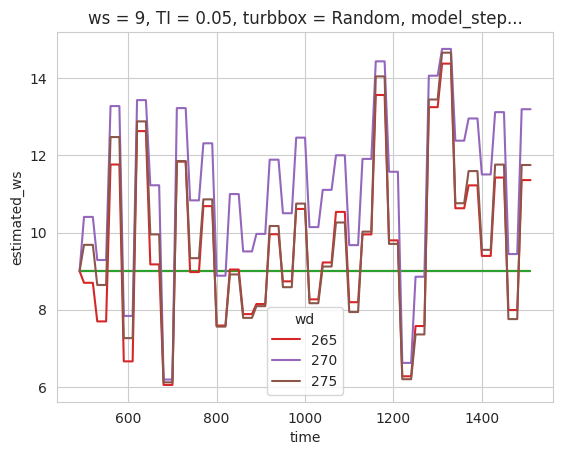

In [41]:
oracle.estimated_ws.plot.line(x="time")
rl.isel(model_step=-1).estimated_ws.plot.line(x="time")